# Improvments on the PreProcessor

First, target encoding functionality has been added to `PreProcessor` class to further support encoding of categorical features. This is especially useful when we have categorical features with high cardinality, where one-hot encoding would result in a big increase in the number of features. Two additional static methods `encoding_recommendations` and `plot_target_encoding_comparison` were also added to support users' decision making regarding encoding strategires. 

* Use `encoding_recommendations` method to identify the recommended encoding strategy (one-hot or target encoding) for each categorical features based on 
    * cadinality,
    * existance of rare categories
    * model type 
* For features to be target encoded, use `plot_target_encoding_comparison` to compare the performance of different smoothing parameters
* Finally, pass a list of categorical features as `target_encode_cols` to be target encoded with the selected `target_encode_smooth` strategy. Any categorical features not included in the list will be one-hot encoded. 

In addition, the PreProcessor class can also offer a `filter_feature_selection` method to go through all features and recommend dropping the ones 
* with too many missings (default threshold set at 20% and is adjustable), or
* has only one unique value, or 
* relate too weakly with the target variable measured by normalized mutual information (default threshold set at 0.1 and is adjustable)

## Mean Encoding for Categorical Features

Based on evaluating two potential approaches for implementing mean encoding functionality in our preprocessing pipeline, the preferred approach is creating a separate `MeanEncoder` class rather than integrating it directly into the existing `PreProcessor` class. This decision aligns with the Single Responsibility Principle and mirrors our current architecture, where numeric and categorical transformations are handled as distinct operations. A separate `MeanEncoder` class will not only be easier to test, maintain, and extend, but will also provide the flexibility to implement advanced features such as cross-validation folds and smoothing parameters. While this approach requires managing an additional class and its interactions, the benefits of improved modularity, reusability, and cleaner code organization outweigh these minor drawbacks.

In [170]:
# Basic dependencies
import random
from typing import Any
import numpy as np
import pandas as pd
import os
import multiprocessing
import re
n_cores = multiprocessing.cpu_count()
n_jobs = max(1, n_cores // 2)  
os.environ["LOKY_MAX_CPU_COUNT"] = str(n_jobs)

# ML 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.datasets import (
    fetch_california_housing,
    fetch_openml,
    load_breast_cancer,
    make_classification
)
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import fbeta_score, roc_auc_score, mutual_info_score, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, TargetEncoder
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
import lightgbm as lgb
import mlflow.pyfunc
import shap
from hyperopt import STATUS_OK, Trials, fmin, hp, space_eval, tpe

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns



## Approach Evaluation

### 1. Using Existing Package (sklearn)
* **Benefits**:
    * No additional dependencies (sklearn is a standard ML requirement)
    * Proven, tested implementation
    * Community support and maintenance
    * Time-saving for basic functionality
    * Potential to contribute improvements:
        * Can benefit wider community
        * Learn from expert code reviews
        * Leverage existing test infrastructure
    * Future maintenance handled by community

### 2. Building from Scratch
* **Benefits**:
    * Complete control over implementation
    * Can perfectly match specific requirements
    * Better understanding of the codebase
    * Easier to extend with custom functionality
* **Drawbacks**:
    * More time to implement
    * Need to write own tests
    * Need to handle edge cases
    * Risk of introducing bugs

### Decision
For this repository, we will incorporate sklearn's TargetEncoder into our PreProcessor class because:
1. Avoids additional dependencies
2. Leverages well-tested implementation
3. Aligns with existing sklearn-based architecture

# The Updated PreProcessor

Below pls see the PreProcessor class updated with the follwoing new methods/Features to support target encoding
* Added option to target encode some columns
    * by leverating sklearn `TargetEncoder`
    * take user input of `target_encode_cols` to return the encoded column
    * optionally, user can specify `target_encode_smooth`, other wise use the default "auto" smoothing    
* Added `identify_encoding_candidates` 
    * to help user determine encoding strategy for categorical features
    * based on user specified model type and analysis of column characteristics such as cardinality, rare category, and missings. 
* Added `plot_target_encoding_comparison`
    * allow user to experiment with different target encoding strategy and
    * visualize the resuilts for easy comparison and decision making


In [171]:
class PreProcessor(BaseEstimator, TransformerMixin):
    """
    Custom transformer for data preprocessing.
    
    - Scales numeric features
    - Encodes categorical features
    - Handles missing values via imputation
    - Compatible with scikit-learn pipeline
    
    Attributes:
        num_impute_strategy (str): Numeric imputation strategy
        cat_impute_strategy (str): Categorical imputation strategy
        num_transformer (Pipeline): Numeric preprocessing pipeline
        cat_transformer (Pipeline): Categorical preprocessing pipeline
        target_encoder (TargetEncoder): Sklearn target encoder for mean encoding
        transformed_cat_cols (List[str]): One-hot encoded column names
        num_features (List[str]): Numeric feature names
        cat_features (List[str]): Categorical feature names
        target_encode_cols (List[str]): Columns for target encoding
        target_encode_smooth (Union[str, float]): Smoothing parameter for target encoding
    """

    def __init__(self, num_impute_strategy='median', 
                 cat_impute_strategy='most_frequent',
                 target_encode_cols=None,
                 target_encode_smooth='auto'):
        """
        Initialize the transformer.
        
        - Sets up numeric data transformer
        - Sets up categorical data transformer
        - Configures imputation strategies

        
        Parameters:
            num_impute_strategy (str): Strategy for numeric missing values
            cat_impute_strategy (str): Strategy for categorical missing values
            target_encode_cols (List[str]): Columns to apply mean encoding
            target_encode_smooth (Union[str, float]): Smoothing parameter for target encoding,
                                                      'auto' or float value (default='auto')
        """
        self.num_impute_strategy = num_impute_strategy
        self.cat_impute_strategy = cat_impute_strategy
        self.target_encode_cols = target_encode_cols
        self.target_encode_smooth = target_encode_smooth

    def fit(self, X, y=None):
        """
        Fit transformer on input data.
        
        - Identifies feature types
        - Configures feature scaling
        - Sets up encoding
        - Fits imputation strategies
        
        Parameters:
            X (pd.DataFrame): Input features
            y (pd.Series, optional): Target variable, not used
        
        Returns:
            CustomTransformer: Fitted transformer
        """
        if self.target_encode_cols and y is None:
            raise ValueError("Target variable y is required when target_encode_cols is specified")
        
        if self.target_encode_cols:
            missing_cols = [col for col in self.target_encode_cols if col not in X.columns]
            if missing_cols:
                raise ValueError(f"Columns {missing_cols} not found in input data")

        self.num_features = X.select_dtypes(include=np.number).columns.tolist()
        self.cat_features = [col for col in X.select_dtypes(exclude=np.number).columns 
                             if col not in (self.target_encode_cols or [])]
               
        # Handle target encoding features
        if self.target_encode_cols:
            self.target_encoder = TargetEncoder(
                smooth=self.target_encode_smooth,
                cv=5
            )
            target_encode_features = [f for f in self.target_encode_cols if f in X.columns]
            if target_encode_features:
                self.target_encoder.fit(X[target_encode_features], y)

        if self.num_features:
            self.num_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy=self.num_impute_strategy)),
                ('scaler', StandardScaler())
            ])
            self.num_transformer.fit(X[self.num_features])
        
        if self.cat_features:
            self.cat_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy=self.cat_impute_strategy)),
                ('encoder', OneHotEncoder(handle_unknown='ignore'))
            ])
            self.cat_transformer.fit(X[self.cat_features])
        
        return self

    def get_transformed_cat_cols(self):
        """
        Get transformed categorical column names.
        
        - Creates names after one-hot encoding
        - Combines category with encoded values
        
        Returns:
            List[str]: One-hot encoded column names
        """
        if not hasattr(self, 'cat_transformer'):
            return []
        
        cat_cols = []
        cats = self.cat_features
        cat_values = self.cat_transformer['encoder'].categories_
        for cat, values in zip(cats, cat_values):
            cat_cols += [re.sub(r'[^a-zA-Z0-9_]', '_', f'{cat}_{value}') for value in values]
        
        return cat_cols

    def transform(self, X):
        """
        Transform input data.
        
        - Applies fitted scaling
        - Applies fitted encoding
        - Handles numeric and categorical features
        
        Parameters:
            X (pd.DataFrame): Input features
        
        Returns:
            pd.DataFrame: Transformed data
        """
        if not hasattr(self, 'num_features'):
            raise ValueError("Transformer not fitted. Call 'fit' before 'transform'.")
        
        transformed_parts = []  # Store transformed components
            
        if self.target_encode_cols and hasattr(self, 'target_encoder'):
            target_encoded_features = self.target_encoder.transform(X[self.target_encode_cols])
            target_encoded_df = pd.DataFrame(target_encoded_features, columns=self.target_encode_cols, index=X.index)
            transformed_parts.append(target_encoded_df)

        if self.num_features:
            transformed_num_data = self.num_transformer.transform(X[self.num_features])
            transformed_num_df = pd.DataFrame(transformed_num_data, columns=self.num_features, index=X.index)
            transformed_parts.append(transformed_num_df)

        if self.cat_features:
            transformed_cat_data = self.cat_transformer.transform(X[self.cat_features]).toarray()
            self.transformed_cat_cols = self.get_transformed_cat_cols()
            transformed_cat_df = pd.DataFrame(transformed_cat_data, columns=self.transformed_cat_cols, index=X.index)
            transformed_parts.append(transformed_cat_df)

        # Concatenate all parts at once to avoid fragmentation
        X_transformed = pd.concat(transformed_parts, axis=1)
        
        X_transformed.index = X.index

        return X_transformed

    def fit_transform(self, X, y=None):
        """
        Fit and transform input data.
        
        - Fits transformer to data
        - Applies transformation
        - Combines both operations
        
        Parameters:
            X (pd.DataFrame): Input features
            y (pd.Series, optional): Target variable, not used
        
        Returns:
            pd.DataFrame: Transformed data
        """
        self.fit(X, y)
        return self.transform(X)
    
    @staticmethod
    def plot_target_encoding_comparison(X_train, y_train, smooth_params, 
                                        target_col, figsize=(15, 6)):
        """
        Plot target encoding comparison with different smoothing parameters.
        
        Parameters:
            X_train (pd.DataFrame): Training features
            y_train (pd.Series): Target variable
            smooth_params (List[Union[str, float]]): List of smoothing parameters to compare
            target_col (str): Column name for target encoding (default='city')
            figsize (tuple): Figure size (default=(15, 6))
        
        Returns:
            dict: Dictionary containing the results for each smoothing parameter
        """
        # Create subplots
        fig, axes = plt.subplots(1, len(smooth_params), figsize=figsize)
        if len(smooth_params) == 1:
            axes = [axes]
        
        results_dict = {}
        global_mean = y_train.mean()
        
        # Create plots for each smoothing parameter
        for ax, smooth in zip(axes, smooth_params):
            # Initialize and fit preprocessor
            preprocessor = PreProcessor(
                num_impute_strategy='median',
                cat_impute_strategy='most_frequent',
                target_encode_cols=[target_col],
                target_encode_smooth=smooth
            )
            X_processed = preprocessor.fit_transform(X_train, y_train)
            
            # Calculate statistics
            original_mean = y_train.groupby(X_train[target_col], observed=False).mean()
            encoded_mean = X_processed.groupby(X_train[target_col], observed=False)[target_col].mean()
            sample_size = X_train[target_col].value_counts().sort_index()

            results = pd.concat([
                original_mean.rename('Original_Train_Mean'),
                encoded_mean.rename('Encoded_Mean'),
                sample_size.rename('Sample_Size')
            ], axis=1).sort_index()
            
            results_dict[smooth] = results
            
            # Create bar plot
            results[['Original_Train_Mean', 'Encoded_Mean']].plot(kind='bar', width=0.8, ax=ax)
            ax.axhline(y=global_mean, color='r', linestyle='--', alpha=0.5,
                    label=f'Global Mean ({global_mean:.3f})')
            
            # Set title and labels
            smooth_label = 'auto' if smooth == 'auto' else str(smooth)
            ax.set_title(f'smooth={smooth_label}')
            ax.set_xlabel('Category')
            ax.set_ylabel('Mean Value')
            
            # Add sample sizes to x-labels
            ax.set_xticks(range(len(results)))
            ax.set_xticklabels([f'{idx}\n(n={results["Sample_Size"][idx]})' 
                            for idx in results.index], 
                            rotation=45)
            ax.legend()
        
        plt.tight_layout()
        plt.show()
        
        return results_dict
    
   
    @staticmethod
    def encoding_recommendations(X: pd.DataFrame, 
                                    high_cardinality_threshold: int = 10, 
                                    rare_category_threshold: int = 30,
                                    model_type: str = 'tree') -> dict:
        """
        Analyze each categorical features based on cardinalityy, rare category and model type to recommend either 
        one-hot encoding or target encoding. Recommend running filter_feature_selection first before doing this
        analysis.
        
        Parameters:
            X (pd.DataFrame): Features
            high_cardinality_threshold (int): Number of unique values above which a column 
                                            is considered high cardinality (default: 10)
            rare_category_threshold (int): Minimum samples per category, below which a 
                                        category is considered rare (default: 30)
            model_type (str): Type of model ('tree' or 'linear', default: 'tree')
        
        Returns:
            dict: Dictionary containing:
                - 'high_cardinality_cols': List of high cardinality columns
                - 'target_encode_cols': List of columns suitable for target encoding
                - 'onehot_encode_cols': List of columns suitable for one-hot encoding
                - 'analysis': DataFrame showing detailed analysis for each categorical column
        """
        categorical_cols = X.select_dtypes(include=['object', 'category']).columns
        
        if len(categorical_cols) == 0:
            print("No categorical columns found in the dataset.")
            return {'high_cardinality_cols': [], 'target_encode_cols': [], 
                    'onehot_encode_cols': [], 'analysis': pd.DataFrame()}
        
        analysis_data = []
        high_cardinality_cols = []
        target_encode_cols = []
        onehot_encode_cols = []
        
        for col in categorical_cols:
            print("-" * 25)
            print(f"Column `{col}` Analysis:")

            missing_rate = X[col].isna().mean()           
            n_unique = X[col].nunique()
            value_counts = X[col].value_counts()
            min_category_size = value_counts.min()
            rare_categories = (value_counts < rare_category_threshold).sum()
            
            analysis = {
                'column': col,
                'missing_rate': missing_rate,
                'unique_values': n_unique,
                'min_category_size': min_category_size,
                'rare_categories': rare_categories
            }

            analysis_data.append(analysis)            
            
            # Categorize columns based on cardinality
            if n_unique > high_cardinality_threshold:
                high_cardinality_cols.append(col)
                target_encode_cols.append(col)
                if rare_categories > 0:
                    analysis['encoding_note'] = (
                        f'Has {rare_categories} rare categories. '
                        f'Recommend higher smoothing for target encoding.'
                    )
                    min_samples_per_cat = value_counts.min()
                    recommended_smoothing = max(100, int(1000 / min_samples_per_cat))
                    analysis['recommended_smoothing'] = recommended_smoothing
                    print(f"Recommend target encoding with higher smoothing parameter due to high cardinality and rare categories")
                else:
                    print(f"Recommend target encoding due to high cardinality")
            elif n_unique <= 2:
                onehot_encode_cols.append(col)
                print(f"Recommend one-hot encoding as the number of unique value is less or equal to 2")
            else:  # Low to moderate cardinality
                if rare_categories > 0:
                    if model_type == 'linear':
                        target_encode_cols.append(col)
                        analysis['encoding_note'] = (
                            f'Linear model'
                            f'Has {rare_categories} rare categories. '
                            f'Recommend higher smoothing for target encoding.'
                        )
                        min_samples_per_cat = value_counts.min()
                        recommended_smoothing = max(100, int(1000 / min_samples_per_cat))
                        analysis['recommended_smoothing'] = recommended_smoothing
                        print(f"Recommend target encoding with higher smoothing (e.g., {recommended_smoothing}), due to moderate cardinality, rare category and linear model")
                    else:
                        onehot_encode_cols.append(col)
                        print(f"Recommend one-hot encoding, due to moderate cardinality, rare category and tree model")
                else:
                    target_encode_cols.append(col)
                    print(f"Recommend target encoding due to moderate cardinality and sufficient sample size")

            # Print detailed column info
            print(f"\ncolumn `{col}` details:")
            print(f"• Missing rate: {missing_rate:.1%}")
            print(f"• Unique values: {n_unique}")
            print(f"• Minimum category size: {min_category_size}")
            print(f"• Rare categories: {rare_categories}")
            if 'encoding_note' in analysis:
                print(f"• Note: {analysis['encoding_note']}")
                    

        analysis_df = pd.DataFrame(analysis_data)        
        
        # Summary counts
        print("-" * 25)
        print("\nSummary:")
        print(f"• Target encoding cols: {len(target_encode_cols)}")
        print(f"• One-hot encoding cols: {len(onehot_encode_cols)}")
        
        return {
            'high_cardinality_cols': high_cardinality_cols,
            'target_encode_cols': target_encode_cols,
            'onehot_encode_cols': onehot_encode_cols,
            'analysis': analysis_df
        }
    

    @staticmethod
    def filter_feature_selection(X: pd.DataFrame, 
                            y: pd.Series, 
                            task: str = 'classification',
                            missing_threshold: float = 0.2,
                            mi_threshold: float = 0.1,
                            random_state: int = 42) -> dict:
        """
        Analyzes features and recommends which ones to keep or drop based on data quality metrics.
        
        This method evaluates features based on three main criteria:
        1. Missing values: Features with missing values exceeding the threshold are recommended for dropping
        2. Unique values: Features with only one unique value (no variance) are recommended for dropping
        3. Mutual information: Features with low mutual information with the target are recommended for dropping
        
        Mutual information is calculated with either `mutual_info_classif` or `mutual_info_regression` based on 
        user specified task. 
        
        Parameters:
            X (pd.DataFrame): Features to analyze
            y (pd.Series): Target variable
            task (str): Type of ML task - 'classification' or 'regression'
            missing_threshold (float): Maximum acceptable proportion of missing values (default: 0.2 or 20%)
            mi_threshold (float): Minimum acceptable normalized mutual information score (default: 0.1 or 10%)
            random_state (int): Random seed for mutual information calculation (default: 42)
            
        Returns:
            dict: Dictionary containing:
                - 'columns_to_drop': List of all columns recommended for dropping
                - 'selected_cols': List of columns recommended to keep
                - 'drop_by_missing': List of columns with too many missing values
                - 'drop_by_unique': List of columns with only one unique value
                - 'drop_by_low_mi': List of columns with low mutual information
                - 'analysis': DataFrame with detailed analysis for each feature
                - 'thresholds': Dictionary with the thresholds used for filtering
        """
        # Create copy to avoid modifying original
        X_proc = X.copy()
        
        # Handle missing and encode categories to calculate mutual info
        discrete_features = np.array([dtype.name in ['category', 'object', 'bool'] for col, dtype in zip(X_proc.columns, X_proc.dtypes)])
        cat_columns = X_proc.select_dtypes(include=['object', 'category']).columns
        for col in X_proc.columns:
            if col in cat_columns:
                most_frequent = X_proc[col].mode()[0]
                X_proc[col] = X_proc[col].fillna(most_frequent)
                X_proc[col] = pd.Categorical(X_proc[col]).codes
            else:
                X_proc[col] = X_proc[col].fillna(X_proc[col].median())
        
        # Calculate mutual info
        if task == 'classification':
            mi_scores = mutual_info_classif(X_proc, y, 
                                        discrete_features=discrete_features,
                                        random_state=random_state)
        elif task == 'regression':
            mi_scores = mutual_info_regression(X_proc, y, 
                                            discrete_features=discrete_features,
                                            random_state=random_state)
        else:
            raise ValueError("task must be 'classification' or 'regression'")
        

        analysis = pd.DataFrame({
            'feature': X.columns,
            'missing_ratio': X.isnull().mean(),
            'n_unique': X.nunique(),
            'n_unique_ratio': X.nunique() / len(X),
            'dtype': X.dtypes,
            'is_discrete': discrete_features
        })  
           
        # Add MI scores and feature type info to analysis
        analysis['mutual_info'] = mi_scores
        analysis['mutual_info_normalized'] = mi_scores / np.nanmax(mi_scores)
        analysis['is_discrete'] = discrete_features

        # Sort analysis by mutual_info_normalized for better readability
        analysis = analysis.sort_values('mutual_info_normalized', ascending=False)

        # Add reasons for dropping
        analysis['drop_missing'] = analysis['missing_ratio'] > missing_threshold
        analysis['drop_unique'] = analysis['n_unique'] <= 1
        analysis['drop_mi'] = analysis['mutual_info_normalized'] < mi_threshold
        
        # Get lists of columns for each drop reason
        cols_missing = analysis[analysis['drop_missing']]['feature'].tolist()
        cols_unique = analysis[analysis['drop_unique']]['feature'].tolist()
        cols_low_mi = analysis[analysis['drop_mi']]['feature'].tolist()

       
        cols_to_drop = list(set(cols_missing + cols_unique + cols_low_mi))
        selected_cols = list(analysis[~analysis['feature'].isin(cols_to_drop)]['feature'])
        
        # Print summary with specific columns
        print(f"Feature Analysis Summary:")
        print(f"Total features analyzed: {len(X.columns)}")
        print(f"\nRecommended drops ({len(cols_to_drop)} total):\n")
        
        print(f"1. High missing ratio (>{missing_threshold*100}%): {len(cols_missing)} columns")
        if cols_missing:
            print("   Columns:", ", ".join(cols_missing))
        
        print(f"\n2. Single value: {len(cols_unique)} columns")
        if cols_unique:
            print("   Columns:", ", ".join(cols_unique))
        
        print(f"\n3. Low mutual information (<{mi_threshold}): {len(cols_low_mi)} columns")
        if cols_low_mi:
            print("   Columns:", ", ".join(cols_low_mi))       

        
        return {
            'columns_to_drop': cols_to_drop,
            'selected_cols': selected_cols,
            'drop_by_missing': cols_missing,
            'drop_by_unique': cols_unique,
            'drop_by_low_mi': cols_low_mi,
            'analysis': analysis,
            'thresholds': {
                'missing_threshold': missing_threshold,
                'mi_threshold': mi_threshold
            }
        }
    
   

In [172]:

# Create demo dataset
np.random.seed(42)
n_samples = 1000
data = pd.DataFrame({
    # Numeric features
    'age': np.random.normal(35, 10, n_samples),
    'income': np.random.lognormal(100, 10, n_samples),
    'tenure': np.random.poisson(5, n_samples),
    
    # Categorical features with low cardinality
    'education': np.random.choice(['High School', 'Bachelor', 'Master or above'], n_samples),
    'occupation': np.random.choice(['Engineer'], n_samples), #only one value
    
    # Categorical features with higher cardinality
    'city': np.random.choice(
        ['NYC']*500 + ['LA']*300 + ['Chicago']*150 + ['Miami']*30 + ['Seattle']*20,
        n_samples
    ),
    'product': np.random.choice(
        ['A']*600 + ['B']*250 + ['C']*80 + ['D']*30 + ['E']*20 + ['F']*20,
        n_samples
    )
})

# Add some missing values
data.loc[np.random.choice(n_samples, 50), 'age'] = np.nan
data.loc[np.random.choice(n_samples, 30), 'education'] = np.nan
data.loc[np.random.choice(n_samples, 20), 'city'] = np.nan

# Create target variable that depends on features
target = pd.Series(np.random.binomial(1, 0.5, n_samples))
target.loc[data['city'] == 'NYC'] = np.random.binomial(1, 0.8, sum(data['city'] == 'NYC'))
target.loc[data['city'] == 'Seattle'] = np.random.binomial(1, 0.2, sum(data['city'] == 'Seattle'))
target.loc[data['product'] == 'A'] = np.random.binomial(1, 0.7, sum(data['product'] == 'A'))
target.loc[data['product'] == 'E'] = np.random.binomial(1, 0.1, sum(data['product'] == 'E'))

# Split data
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)


## Filter Feature Selection

In [173]:
fitler_fs = PreProcessor.filter_feature_selection(X_train, y_train,
                                                  task = "classification",
                                                  missing_threshold = 0.2,
                                                  mi_threshold = 0.05)

Feature Analysis Summary:
Total features analyzed: 7

Recommended drops (3 total):

1. High missing ratio (>20.0%): 0 columns

2. Single value: 1 columns
   Columns: occupation

3. Low mutual information (<0.05): 3 columns
   Columns: age, tenure, occupation


In [174]:
X_train.shape

(800, 7)

In [175]:
fitler_fs['analysis']

,feature,missing_ratio,n_unique,n_unique_ratio,dtype,is_discrete,mutual_info,mutual_info_normalized,drop_missing,drop_unique,drop_mi
city,city,0.0200,5,0.00625,object,True,0.016899,1.000000,False,False,False
product,product,0.0000,6,0.00750,object,True,0.011228,0.664413,False,False,False
income,income,0.0000,800,1.00000,float64,False,0.001354,0.080128,False,False,False
education,education,0.0275,3,0.00375,object,True,0.000904,0.053503,False,False,False
age,age,0.0475,762,0.95250,float64,False,0.000000,0.000000,False,False,True
tenure,tenure,0.0000,13,0.01625,int32,False,0.000000,0.000000,False,False,True
occupation,occupation,0.0000,1,0.00125,object,True,0.000000,0.000000,False,True,True


In [176]:
selected_cols = fitler_fs['selected_cols']
print("Selected columbns include:", ", ".join(selected_cols))

Selected columbns include: city, product, income, education


## Recommend encoding candidates

The `identify_encoding_candidates` method determines optimal encoding based on:

1. **High Cardinality Features** (>10 unique values):
   - Mean encoding if sufficient samples per category
   - Otherwise, consider dropping or grouping rare categories

2. **Binary Features** (2 unique values):
   - Always one-hot encode for simplicity and interpretability

3. **Medium Cardinality Features** (3-10 unique values):
   - Consider dropping if target relationship is weak (relative mean range < 10%)
   - For tree models: One-hot encode by default
   - For linear models: Mean encode if there's strong target relationship AND no rare categories
   

The method analyzes sample sizes, target relationships, and model type to provide recommendations that balance predictive power with model interpretability.

In [177]:
encoding_recommendations = PreProcessor.encoding_recommendations(X_train[selected_cols], high_cardinality_threshold=5)

-------------------------
Column `city` Analysis:
Recommend one-hot encoding, due to moderate cardinality, rare category and tree model

column `city` details:
• Missing rate: 2.0%
• Unique values: 5
• Minimum category size: 24
• Rare categories: 2
-------------------------
Column `product` Analysis:
Recommend target encoding with higher smoothing parameter due to high cardinality and rare categories

column `product` details:
• Missing rate: 0.0%
• Unique values: 6
• Minimum category size: 14
• Rare categories: 3
• Note: Has 3 rare categories. Recommend higher smoothing for target encoding.
-------------------------
Column `education` Analysis:
Recommend target encoding due to moderate cardinality and sufficient sample size

column `education` details:
• Missing rate: 2.8%
• Unique values: 3
• Minimum category size: 247
• Rare categories: 0
-------------------------

Summary:
• Target encoding cols: 2
• One-hot encoding cols: 1


In [178]:
# access the detailed analysis in dataframe form if preferred
encoding_recommendations['analysis']

,column,missing_rate,unique_values,min_category_size,rare_categories,encoding_note,recommended_smoothing
0,city,0.0200,5,24,2,NaN,NaN
1,product,0.0000,6,14,3,Has 3 rare categories. Recommend higher smooth...,100.0
2,education,0.0275,3,247,0,NaN,NaN


In [179]:
# product will be considered a column with high cardinality as 5 was input as the high_cardinality_threshold above
encoding_recommendations['high_cardinality_cols']

['product']

In [180]:
# this high cardinality feature is then recommended for target_encoding
encoding_recommendations['target_encode_cols']

['product', 'education']

In [181]:
target_encode_cols = encoding_recommendations['target_encode_cols']
preprocessor = PreProcessor(
    target_encode_cols=target_encode_cols,
    target_encode_smooth='auto'
)
X_train_preprocessed = preprocessor.fit_transform(X_train[selected_cols],y_train)
X_test_preprocessed =  preprocessor.transform(X_test[selected_cols])

In [182]:
X_test_preprocessed.head()

,product,education,income,city_Chicago,city_LA,city_Miami,city_NYC,city_Seattle
521,0.686409,0.652251,-0.048737,1.0,0.0,0.0,0.0,0.0
737,0.681542,0.659965,-0.048737,0.0,1.0,0.0,0.0,0.0
740,0.681542,0.659965,-0.048737,0.0,0.0,0.0,1.0,0.0
660,0.681542,0.694165,-0.048736,0.0,0.0,0.0,1.0,0.0
411,0.686409,0.659965,-0.048737,0.0,0.0,0.0,1.0,0.0


## Compare Smoothing Strategies

Once the target encoding columns have been selected, the next decision we need to make is about the best smoothing strategies, which can be used to balance between the raw category means and the global mean to avoid overfitting. Two main smoothing strategies are available:

1. 'auto' - Automatically determines the smoothing parameter based on the dataset characteristics
2. Custom float value - Manually specify the smoothing strength (higher values = more smoothing)

As shown above, different smoothing strategies returns diffent result for a column of interests. The `plot_target_encoding_comparison` method visualizes how different smoothing parameters affect the encoded values. This is especially critical for categorical features with rare categories where overfitting is a bigger concern. Pls see below the visualization of `city`, where rare categories exist, and `education` with sufficiant sample sizes for each category. Smoothing parameters make a big difference for `city` and in particular the rare cagtegory Seattle whose train mean is much lower than the global mean. But for `education`, the 

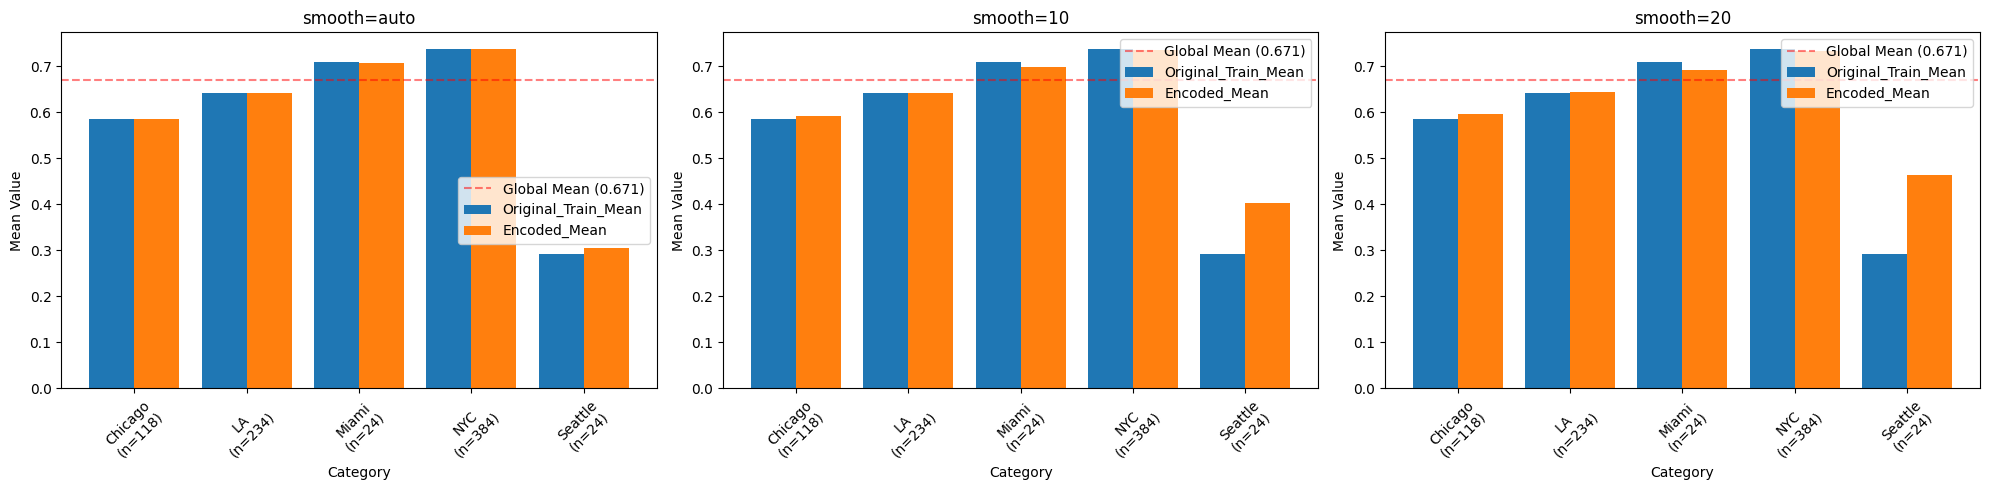

In [183]:
results = PreProcessor.plot_target_encoding_comparison(X_train, y_train, 
                                        target_col= 'city',  
                                        smooth_params=['auto', 10, 20],
                                        figsize=(20, 5))

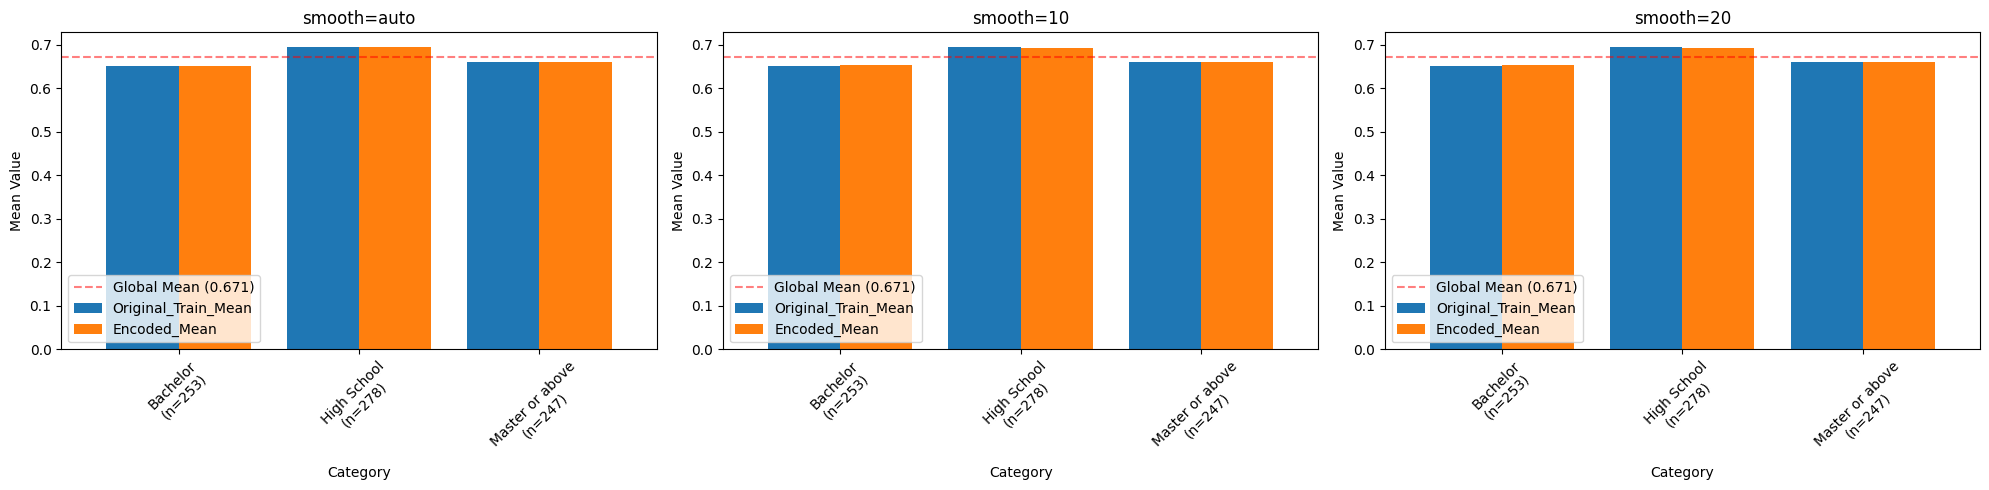

In [184]:
results = PreProcessor.plot_target_encoding_comparison(X_train, y_train, 
                                        target_col= 'education',  
                                        smooth_params=['auto', 10, 20],
                                        figsize=(20, 5))

# Improvements on the ML_PIPELINE

* evaluation reports and plots
    * classification models
        * metrics
            * AUC
            * F1
            * Fbeta (if beta specified by user)
            * precision
            * recall
        * Plots
            * ROC_AUC curve
            * precision-recall curve
    * regression models
        * metrics
            * RMSE (Root Mean Squared Error)
            * NRMSE (Normalized RMSE as % of target mean)
            * MAPE (Mean Absolute Percentage Error)
            * R² Score
            * Improvement over baseline (%)
        * Plots
            * Residual analysis (residuals vs predicted values)
            * Prediction error plot (actual vs predicted with error bands)
        

In [185]:
class ML_PIPELINE(mlflow.pyfunc.PythonModel):
    """
    Custom ML pipeline for classification and regression.
    
    - Works with scikit-learn compatible models
    - Handles data preprocessing
    - Manages model training and predictions
    - Provide global and local model explanation
    - Compatible with MLflow tracking
    - Supports MLflow deployment

    Attributes:
        model (BaseEstimator or None): A scikit-learn compatible model instance
        preprocessor (Any or None): Data preprocessing pipeline
        config (Any or None): Optional config for model settings 
        task(str): Type of ML task ('classification' or 'regression')
        n_features (int): Number of features after preprocessing
        both_class (bool): Whether SHAP values include both classes
        shap_values (shap.Explanation): SHAP values for model explanation
        X_explain (pd.DataFrame): Processed features for SHAP explanation
    """

    def __init__(self, model: BaseEstimator = None, preprocessor = None, config = None):
        """
        Initialize the ML_PIPELINE with an optional model, preprocessor, and configuration.

        Parameters:
            model (BaseEstimator, optional): A scikit-learn compatible model, such as LightGBM 
                or XGBoost, for training and predictions. Defaults to None.
            preprocessor (Any, optional): A transformer or pipeline used to preprocess the input 
                data. Defaults to None.
            config (Any, optional): Additional configuration settings for the model, if needed. 
                Defaults to None.
        """
        self.model = model
        self.preprocessor = preprocessor
        self.config = config
        self.task = "classification" if hasattr(self.model, "predict_proba") else "regression"
        self.shap_values = None

    def fit(self, X_train: pd.DataFrame, y_train: pd.Series,
            eval_set=None, early_stopping_rounds=None):
        """
        Train the model using the provided training data, after applying preprocessing.

        Parameters:
            X_train (pd.DataFrame): A DataFrame containing feature columns for training.
            y_train (pd.Series): A Series containing the target variable values.
        """
        if self.preprocessor is not None:
            X_train_preprocessed = self.preprocessor.fit_transform(X_train.copy(), y_train.copy())
        else:
            X_train_preprocessed = X_train.copy()

        self.n_features = X_train_preprocessed.shape[1]
        
        # Prepare fit parameters
        fit_params = {}
        if eval_set is not None:
            X_val, y_val = eval_set
            X_val_transformed = self.preprocessor.transform(X_val)
            fit_params['eval_set'] = [(X_val_transformed, y_val)]
            
            if early_stopping_rounds is not None:
                fit_params['early_stopping_rounds'] = early_stopping_rounds

        self.model.fit(X_train_preprocessed, y_train, **fit_params)

    def predict(
            self, context: Any, model_input: pd.DataFrame
            ) -> np.ndarray:
        """
        Make predictions using the pre-trained model, applying preprocessing to the input data.

        Parameters:
            context (Any): Optional context information provided by MLflow during the 
                prediction phase.
            model_input (pd.DataFrame): The DataFrame containing input features for predictions.

        Returns:
            Any: A NumPy array or DataFrame with the predicted probabilities or output values.
        """
        if self.preprocessor is not None:
            processed_model_input = self.preprocessor.transform(model_input.copy())
        else:
            processed_model_input = model_input.copy()
        
        if self.task == "classification":
            prediction = self.model.predict_proba(processed_model_input)[:,1]
        elif self.task == "regression":
            prediction = self.model.predict(processed_model_input)
        return prediction
    
    def explain_model(self,X):
        """
        Generate SHAP values and plots for model interpretation.
        
        This method:
        1. Transforms the input data using the fitted preprocessor
        2. Creates a SHAP explainer appropriate for the model type
        3. Calculates SHAP values for feature importance
        4. Generates a summary plot of feature importance
        
        Parameters:
            X : pd.DataFrame
                Input features to generate explanations for. Should have the same 
                columns as the training data.
        
        Returns: None
            The method stores the following attributes in the class:
            - self.X_explain : pd.DataFrame
                Transformed data with original numeric values for interpretation
            - self.shap_values : shap.Explanation
                SHAP values for each prediction
            - self.both_class : bool
                Whether the model outputs probabilities for both classes          
        """
        if self.preprocessor is not None:
            X_transformed = self.preprocessor.transform(X.copy())
        else:
            X_transformed = X.copy()

        self.X_explain = X_transformed.copy()
        # if trained preprocessor is available, get pre-transformed values for numeric features
        # else, users see the transformed values at the moment
        if self.preprocessor is not None:
            self.X_explain[self.preprocessor.num_features] = X[self.preprocessor.num_features]

        self.X_explain.reset_index(drop=True)
        try:
            # Attempt to create an explainer that directly supports the model
            explainer = shap.Explainer(self.model)
        except:
            # Fallback for models or shap versions where direct support may be limited
            explainer = shap.Explainer(self.model.predict, X_transformed)
        self.shap_values = explainer(X_transformed)  

        # get the shape of shap values and extract accordingly
        self.both_class = len(self.shap_values.values.shape) == 3
        if self.both_class:
            shap.summary_plot(self.shap_values[:,:,1])
        elif self.both_class == False:
            shap.summary_plot(self.shap_values)
    
    def explain_case(self,n):
        """
        Generate SHAP waterfall plot for one specific case.
        
        - Shows feature contributions
        - Starts from base value
        - Ends at final prediction
        - Shows original feature values for better interpretability
        
        Parameters:
            n (int): Case index (1-based)
                     e.g., n=1 explains the first case.
        
        Returns:
            None: Displays SHAP waterfall plot
        
        Notes:
            - Requires explain_model() first
            - Shows positive class for binary tasks
        """
        if self.shap_values is None:
            print("""
                  Please explain model first by running
                  `explain_model()` using a selected dataset
                  """)
        else:
            self.shap_values.data = self.X_explain
            if self.both_class:
                shap.plots.waterfall(self.shap_values[:,:,1][n-1])
            elif self.both_class == False:
                shap.plots.waterfall(self.shap_values[n-1]) 

    def _evaluate_regression_model(self, y_true, y_pred, verbose: bool = False):
        """
        Calculate multiple regression metrics for better interpretability.
        
        Parameters:
            y_true: True target values
            y_pred: Predicted target values
            verbose: If True, prints detailed evaluation metrics and analysis.
                    If False, returns metrics without printing (default=False)
        
        Returns:
            dict: Dictionary of different metrics
        """
        # Basic metrics
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)
        adj_r2 = 1 - (1 - r2) * (n_samples - 1) / (n_samples - self.n_features - 1)
        
        # Scale-independent metrics: mean absolute percentage error
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  
        
        # Normalized RMSE 
        nrmse = rmse / np.mean(y_true) * 100
        
        # Compare to baseline (using mean)
        baseline_pred = np.full_like(y_true, np.mean(y_true))
        baseline_rmse = np.sqrt(mean_squared_error(y_true, baseline_pred))
        rmse_improvement = (baseline_rmse - rmse) / baseline_rmse * 100

        if verbose:         
            print("\nRegression Model Evaluation:")
            print("-" * 40)
            print(f"RMSE: {rmse:.3f}")
            print(f"Normalized RMSE: {nrmse:.1f}% of target mean")
            print(f"MAPE: {mape:.1f}%")
            print(f"R² Score: {r2:.3f}")
            print(f"Adjusted R² Score: {adj_r2:.3f}")
            print(f"Improvement over baseline: {rmse_improvement:.1f}%")
            if r2 - adj_r2 > 0.1:
                print("\nWarning: Large difference between R² and Adjusted R² suggests possible overfitting")
                print(f"- R² dropped by {(r2 - adj_r2):.3f} after adjustment")
                print("- Consider feature selection or regularization")
        
        return {
            'rmse': rmse,
            'nrmse': nrmse,
            'mape': mape,
            'r2': r2,
            'improvement': rmse_improvement
        }
    
    def _evaluate_classification_model(self, y_true: pd.Series, y_pred_proba: np.ndarray,
                                 threshold: float = 0.5, beta: float = 1.0,
                                 verbose: bool = False):
        """
        Calculate classification metrics at a given threshold.
        
        Parameters:
            y_true: True target values
            y_pred_proba: Predicted probabilities
            threshold: Classification threshold (default=0.5)
            beta: Beta value for F-beta score (default=1.0)
            verbose: If True, prints detailed evaluation metrics
        
        Returns:
            dict: Dictionary containing:
                - evaluation parameters (threshold, beta)
                - classification metrics
        """
        # Get predictions at specified threshold
        y_pred = (y_pred_proba >= threshold).astype(int)
        
        # Calculate metrics
        metrics = {
            # Evaluation parameters
            'threshold': threshold,
            'beta': beta,
            
            # Core metrics
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred),
            'recall': recall_score(y_true, y_pred),
            'f1': f1_score(y_true, y_pred),
            'f_beta': fbeta_score(y_true, y_pred, beta=beta),
            'auc': roc_auc_score(y_true, y_pred_proba),
            
            # Additional context
            'positive_rate': np.mean(y_pred)  # % of positive predictions
        }
        
        if verbose:
            print("\nClassification Metrics Report")
            print("=" * 50)
            print(f"\nEvaluation Parameters:")
            print(f"Threshold: {metrics['threshold']:.3f}")
            print(f"Beta:      {metrics['beta']:.3f}")
            print(f"\nMetrics:")
            print(f"Accuracy:  {metrics['accuracy']:.3f}")
            print(f"F1:        {metrics['f1']:.3f}")
            if beta != 1:
                print(f"F_beta:    {metrics['f_beta']:.3f}")
            print(f"Precision: {metrics['precision']:.3f}")
            print(f"Recall:    {metrics['recall']:.3f}")
            print(f"Pos Rate:  {metrics['positive_rate']:.3f}")
            print(f"\nAUC (threshold independent):")
            print(f"AUC:   {metrics['auc']:.3f}")
        
        return metrics
    
    @staticmethod
    def _plot_classification_metrics(y_true: np.ndarray, 
                               y_pred_proba: np.ndarray,
                               threshold: float = 0.5,
                               beta: float = 1.0) -> None:
        """
        Create visualization for classification metrics including ROC curve and Metrics vs Threshold.
        
        Parameters:
            y_true: True labels
            y_pred_proba: Predicted probabilities
            threshold: Classification threshold
            beta: Beta value for F-beta score
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # ROC Curve (left plot)
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        roc_auc = roc_auc_score(y_true, y_pred_proba)
        
        ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
        ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
        
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.set_title('ROC Curve')
        ax1.legend(loc="lower right")
        ax1.grid(True)
        
        # Metrics vs Threshold (right plot)
        thresholds = np.linspace(0, 1, 200)
        precisions = []
        recalls = []
        f_scores = []
        
        for t in thresholds:
            y_pred = (y_pred_proba >= t).astype(int)
            if np.sum(y_pred) > 0:
                prec = precision_score(y_true, y_pred)
                rec = recall_score(y_true, y_pred)
                f_beta = fbeta_score(y_true, y_pred, beta=beta)
                
                precisions.append(prec)
                recalls.append(rec)
                f_scores.append(f_beta)
            else:
                break
        
        valid_thresholds = thresholds[:len(precisions)]
        
        # Current metrics at threshold
        current_precision = precision_score(y_true, y_pred_proba >= threshold)
        current_recall = recall_score(y_true, y_pred_proba >= threshold)
        current_f = fbeta_score(y_true, y_pred_proba >= threshold, beta=beta)
        
        # Plot metrics
        ax2.plot(valid_thresholds, np.array(precisions) * 100, 'b-', label='Precision', lw=2)
        ax2.plot(valid_thresholds, np.array(recalls) * 100, 'r-', label='Recall', lw=2)
        ax2.plot(valid_thresholds, np.array(f_scores) * 100, 'g--', label=f'F{beta:.1f} Score', lw=2)
        
        # Add threshold line with metrics
        ax2.axvline(x=threshold, color='gray', linestyle='--', 
                    label=f'Threshold = {threshold:.3f}\n'
                        f'Precision = {current_precision:.3f}\n'
                        f'Recall = {current_recall:.3f}\n'
                        f'F{beta:.1f} = {current_f:.3f}')
        
        ax2.set_xlabel('Threshold')
        ax2.set_ylabel('Score (%)')
        ax2.set_title('Metrics vs Threshold')
        ax2.legend(loc="center right")
        ax2.grid(True)
        ax2.set_ylim(0, 100)
        
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def _plot_regression_metrics(X_test, y_test, y_pred):
        """
        Create side-by-side diagnostic plots for regression models:
        - Left: Residual analysis (residuals vs predicted)
        - Right: Prediction error plot (actual vs predicted with error bands)
        
        Parameters:
            X_test: test features
            y_test: true target values
            y_pred: model predictions
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Left plot: Residual analysis
        residuals = y_test - y_pred
        ax1.scatter(y_pred, residuals, alpha=0.5)
        ax1.axhline(y=0, color='r', linestyle='--')
        ax1.set_xlabel('Predicted Values')
        ax1.set_ylabel('Residuals')
        ax1.set_title('Residuals vs Predicted')
        
        # Add prediction intervals (±2σ for ~95% confidence)
        std_residuals = np.std(residuals)
        ax1.fill_between(
            [y_pred.min(), y_pred.max()],
            -2 * std_residuals,
            2 * std_residuals,
            alpha=0.2,
            color='gray',
            label='95% Prediction Interval'
        )
        ax1.legend()

        # Right plot: Prediction Error Plot
        ax2.scatter(y_test, y_pred, alpha=0.5)
        
        # Add perfect prediction line
        min_val = min(y_test.min(), y_pred.min())
        max_val = max(y_test.max(), y_pred.max())
        ax2.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
        
        # Add error bands (±2σ)
        sorted_indices = np.argsort(y_test)
        sorted_y_test = y_test.iloc[sorted_indices] if hasattr(y_test, 'iloc') else y_test[sorted_indices]
        sorted_y_pred = y_pred[sorted_indices]
        
        ax2.fill_between(
            sorted_y_test,
            sorted_y_pred - 2*std_residuals,
            sorted_y_pred + 2*std_residuals,
            alpha=0.2,
            color='gray',
            label='95% Prediction Interval'
        )
        
        ax2.set_xlabel('Actual Values')
        ax2.set_ylabel('Predicted Values')
        ax2.set_title('Actual vs Predicted')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()

    def evaluate(self, X_test: pd.DataFrame, y_test: pd.Series, 
                threshold: float = 0.5, beta: float = 1.0,
                verbose: bool = False, visualize: bool = False) -> dict:
        """
        Evaluate model performance using appropriate metrics.
        
        Parameters:
            X_test: Test features DataFrame
            y_test: True target values
            threshold: Classification threshold (default=0.5)
            beta: Beta value for F-beta score (default=1.0)
            verbose: If True, prints detailed evaluation metrics
            visualize: If True, displays relevant visualization plots
        
        Returns:
            dict: Dictionary containing evaluation metrics
        """
        if self.task == "classification":
            y_pred_proba = self.predict(context=None, model_input=X_test)
            metrics = self._evaluate_classification_model(
                y_test, y_pred_proba, threshold, beta, verbose=verbose
            )
            if visualize:
                ML_PIPELINE._plot_classification_metrics(
                    y_test, y_pred_proba, threshold, beta
                )
        else:  # regression
            y_pred = self.predict(context=None, model_input=X_test)
            metrics = self._evaluate_regression_model(
                y_test, y_pred, verbose=verbose
            )
            if visualize:
                self._plot_regression_metrics(X_test, y_test, y_pred)        
        return metrics
        
    
    @staticmethod
    def tune(X, y, algorithm, preprocessor, space, max_evals=500, random_state=42, beta=1, early_stopping_rounds=100, verbose=0, cv=5):
        """
        Static method to tune hyperparameters using AUC and find optimal threshold.
        
        Parameters:
            X: Features
            y: Target
            algorithm: ML algorithm class (e.g., lgb.LGBMClassifier)
            preprocessor (Any or None): Data preprocessing pipeline
            space: Hyperopt parameter search space
            max_evals: Maximum number of evaluations
            random_state: Random seed for reproducibility
            beta: Beta value for F-beta score optimization (default=1.0)
                beta > 1 gives more weight to recall
                beta < 1 gives more weight to precision
            early_stopping_rounds: Stop tuning if no improvement in specified number of trials
            cv: number of splits for cross-validation
                
        Returns:
            dict: Contains:
                - best_params: Best hyperparameters found
        """

        # Split train+test
        X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)


        def objective(params):
            cv_scores = []
            kf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
            
            for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_full, y_train_full)):
                X_fold_train = X_train_full.iloc[train_idx]
                X_fold_val = X_train_full.iloc[val_idx]
                
                # For numpy arrays or pandas Series
                if isinstance(y_train_full, pd.Series):
                    y_fold_train = y_train_full.iloc[train_idx]
                    y_fold_val = y_train_full.iloc[val_idx]
                else:
                    y_fold_train = y_train_full[train_idx]
                    y_fold_val = y_train_full[val_idx]
                
                model = ML_PIPELINE(
                    model=algorithm(**params, verbose=verbose),
                    preprocessor=preprocessor
                )
                
                model.fit(X_fold_train, y_fold_train)
                results = model.evaluate(X_fold_val, y_fold_val)
                cv_scores.append(results['auc'])
            
            mean_auc = np.mean(cv_scores)
            std_auc = np.std(cv_scores)
            
            # penalize high variance solutions
            score = mean_auc - 0.1 * std_auc  
            
            return {'loss': -score, 'status': STATUS_OK}
        
        # Run optimization
        trials = Trials()
        def early_stop_fn(trials, *args):
            if len(trials.trials) < early_stopping_rounds:
                return (False, "Not enough trials")            
            # score for the last early_stopping_rounds, the larger the better
            scores = [-trial['result']['loss'] for trial in trials.trials[-early_stopping_rounds:]]           
                     
            if len(scores) >= early_stopping_rounds and max(scores) == scores[0]:
                return (True, f"No improvement in last {early_stopping_rounds} trials")
            else:
                return (False, "Continuing optimization")
        
        best = fmin(
            fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=max_evals,
            trials=trials,
            rstate=np.random.default_rng(random_state),
            early_stop_fn=early_stop_fn
        )
        
        # Get best parameters and create best pipeline
        best_params = space_eval(space, best)       
        # Train final model with best parameters on full training set
        final_model = ML_PIPELINE(
            model = algorithm(**best_params, verbose=verbose),
            preprocessor = PreProcessor()
        )
        final_model.fit(X_train_full, y_train_full)
        y_pred_proba = final_model.predict(context = None, model_input=X_train_full)
        optimal_threshold = ML_PIPELINE.threshold_analysis(y_train_full, y_pred_proba, beta = beta)['optimal_threshold']
        
        # Print results on new data
        final_results = final_model.evaluate(X_test, y_test, optimal_threshold, beta=beta, verbose=True,visualize=True)
        print("\nHyperparameter Tuning Results")
        print("=" * 50)
        print(f"\nBest parameters found:")
        for param, value in best_params.items():
            print(f"{param}: {value}")
        
        return {
            'best_params': best_params,
            'best_pipeline': final_model,
            'trials': trials,
            'beta': beta, #beta for f_beta
            'optimal_threshold': optimal_threshold, # optimal threshold to maximize f_beta
            'test_auc': final_results['auc'], 
            'test_Fbeta': final_results['f_beta'],
            'test_precision': final_results['precision'],
            'test_recall': final_results['recall'],
        }
    
    @staticmethod
    def threshold_analysis(y_true: pd.Series, y_pred_proba: np.ndarray, 
                        beta: float = 1.0, n_splits: int = 5):
        """
        Identify the optimal threshold that maximize thresholds using cross-validation.
        
        Args:
            y_true: True labels
            y_pred_proba: Predicted probabilities
            beta: F-beta score parameter
            n_splits: Number of CV splits
        """
        # Initialize CV
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        thresholds_cv = []
        curves_cv = []
        
        for train_idx, val_idx in cv.split(y_true, y_true):
            y_true_val = y_true.iloc[val_idx]
            y_pred_proba_val = y_pred_proba[val_idx]
            precisions, recalls, pr_thresholds = precision_recall_curve(y_true_val, y_pred_proba_val)
            fpr, tpr, roc_thresholds = roc_curve(y_true_val, y_pred_proba_val)            
            # Find optimal threshold for this fold
            f_beta_scores = ((1 + beta**2) * (precisions * recalls) / 
                        (beta**2 * precisions + recalls + 1e-10))
            optimal_idx = np.argmax(f_beta_scores)
            optimal_threshold = pr_thresholds[optimal_idx] if len(pr_thresholds) > optimal_idx else 0.5
            
            thresholds_cv.append(optimal_threshold)
        
        return {
            'optimal_threshold': np.mean(thresholds_cv),
            'threshold_std': np.std(thresholds_cv),
            'threshold_cv_values': thresholds_cv       
        }
    
   


# Modeling Demo

## Regression Problem

In [187]:
# Load California Housing dataset, which has no categorical features
housing = fetch_california_housing(as_frame=True)
X = housing.data
y = housing.target

# Create a neighborhood feature based on location which has high cardinality
neighborhoods = (
        pd.qcut(X['Longitude'], q=5).astype(str) + '_' + 
        pd.qcut(X['Latitude'], q=5).astype(str)
    )
unique_neighborhoods = neighborhoods.unique()
readable_names = [f'District_{i+1}' for i in range(len(unique_neighborhoods))]
name_mapping = dict(zip(unique_neighborhoods, readable_names))    
X['Neighborhood'] = neighborhoods.map(name_mapping)

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [188]:
filter_fs = PreProcessor.filter_feature_selection(X_train, y_train, task='regression')

Feature Analysis Summary:
Total features analyzed: 9

Recommended drops (2 total):

1. High missing ratio (>20.0%): 0 columns

2. Single value: 0 columns

3. Low mutual information (<0.1): 2 columns
   Columns: Population, AveBedrms


In [189]:
filter_fs['analysis']

,feature,missing_ratio,n_unique,n_unique_ratio,dtype,is_discrete,mutual_info,mutual_info_normalized,drop_missing,drop_unique,drop_mi
MedInc,MedInc,0.0,9184,0.695284,float64,False,0.396599,1.000000,False,False,False
Longitude,Longitude,0.0,801,0.060640,float64,False,0.383847,0.967848,False,False,False
Latitude,Latitude,0.0,813,0.061549,float64,False,0.348257,0.878107,False,False,False
Neighborhood,Neighborhood,0.0,16,0.001211,object,True,0.216790,0.546623,False,False,False
AveRooms,AveRooms,0.0,12651,0.957756,float64,False,0.094141,0.237371,False,False,False
AveOccup,AveOccup,0.0,12368,0.936331,float64,False,0.072918,0.183859,False,False,False
HouseAge,HouseAge,0.0,52,0.003937,float64,False,0.039978,0.100801,False,False,False
Population,Population,0.0,3396,0.257097,float64,False,0.027711,0.069871,False,False,True
AveBedrms,AveBedrms,0.0,10013,0.758044,float64,False,0.025181,0.063493,False,False,True


In [190]:
# Identify Target Encoding Columns and Select Smoothing Parameter
encoding_recommendations = PreProcessor.encoding_recommendations(X_train)

-------------------------
Column `Neighborhood` Analysis:
Recommend target encoding with higher smoothing parameter due to high cardinality and rare categories

column `Neighborhood` details:
• Missing rate: 0.0%
• Unique values: 16
• Minimum category size: 2
• Rare categories: 1
• Note: Has 1 rare categories. Recommend higher smoothing for target encoding.
-------------------------

Summary:
• Target encoding cols: 1
• One-hot encoding cols: 0


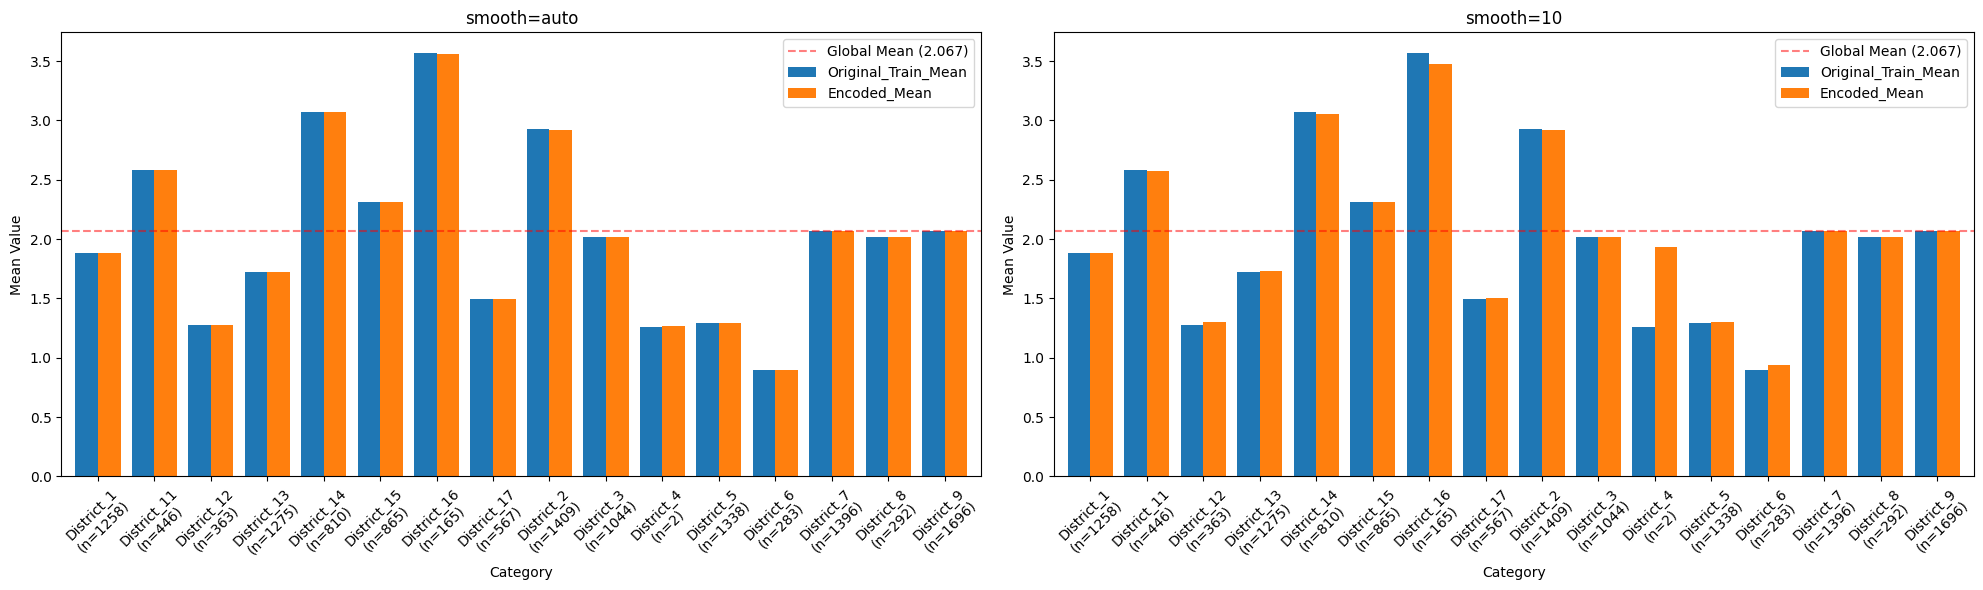

In [191]:
# there is one district with only 5 cases where smoothing will bring the encoded mean much closer to global mean
results = PreProcessor.plot_target_encoding_comparison(X_train, y_train,
                                                       target_col= 'Neighborhood', smooth_params=['auto', 10],
                                                       figsize=(20,6))

In [192]:
# Define, Fit and Use the ML Pipeline
preprocessor = PreProcessor(target_encode_cols=['Neighborhood'], target_encode_smooth=10)

mlpipeline = ML_PIPELINE(
    model = lgb.LGBMRegressor(verbose=-1, early_stopping_rounds = 100),
    preprocessor=preprocessor
)

In [193]:
mlpipeline.fit(X_train, y_train,                
               eval_set=(X_val, y_val))
y_pred = mlpipeline.predict(model_input = X_test, context=None)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"rmse:{rmse:.2f}")

rmse:0.46



Regression Model Evaluation:
----------------------------------------
RMSE: 0.462
Normalized RMSE: 22.5% of target mean
MAPE: 17.7%
R² Score: 0.837
Adjusted R² Score: 0.836
Improvement over baseline: 59.6%


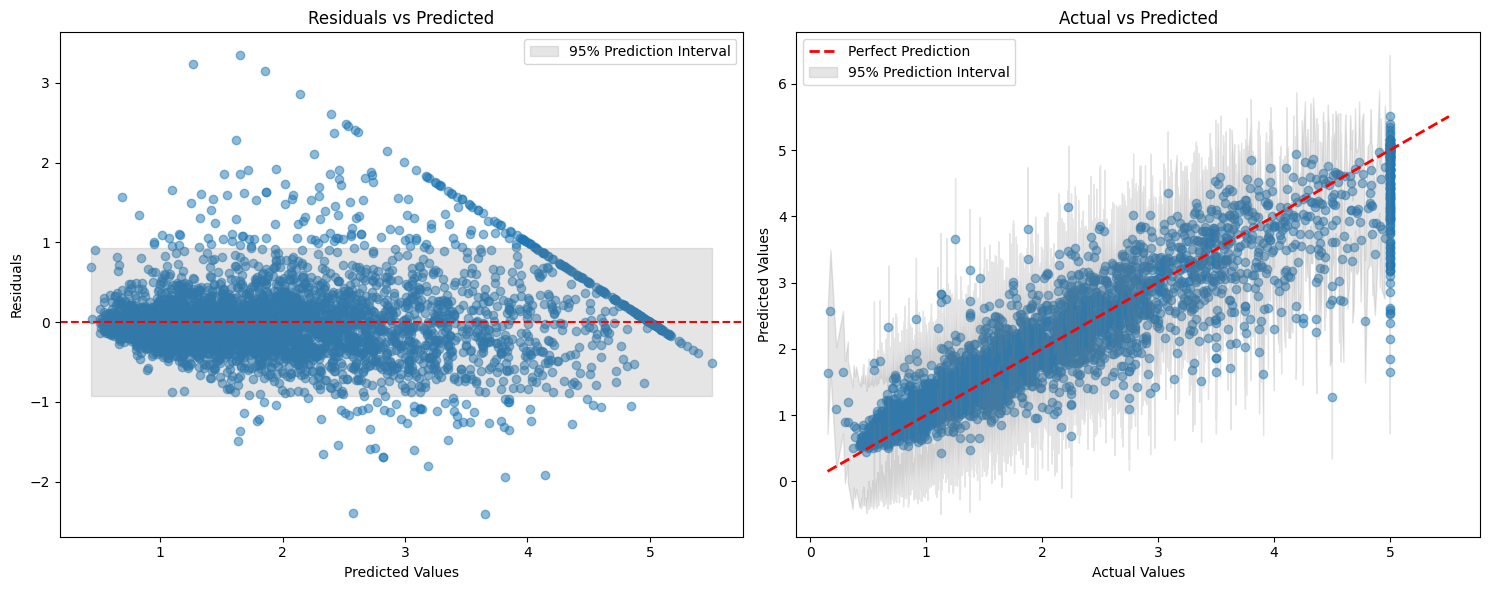

In [194]:
# automatically produce evaluation report on main metrics
metrics = mlpipeline.evaluate(X_test, y_test, verbose=True, visualize=True)

In [195]:
# Easily retrive any particular metric
metrics['rmse']

0.46190176999468263

## Classification Problem

In [196]:
# Load data
titanic = fetch_openml('titanic', version=1, as_frame=True)
X = titanic.data
y = titanic.target.astype(int)  
X = X.drop(['boat', 'body', 'home.dest', 'ticket', 'cabin', 'name'], axis=1)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

ffs = PreProcessor.filter_feature_selection(X_train, y_train)
selected_cols = ffs['selected_cols']


Feature Analysis Summary:
Total features analyzed: 7

Recommended drops (1 total):

1. High missing ratio (>20.0%): 0 columns

2. Single value: 0 columns

3. Low mutual information (<0.1): 1 columns
   Columns: sibsp


In [197]:
ffs['analysis']

,feature,missing_ratio,n_unique,n_unique_ratio,dtype,is_discrete,mutual_info,mutual_info_normalized,drop_missing,drop_unique,drop_mi
sex,sex,0.000000,2,0.002389,category,True,0.137704,1.000000,False,False,False
fare,fare,0.001195,247,0.295102,float64,False,0.113797,0.826389,False,False,False
age,age,0.195938,88,0.105137,float64,False,0.046462,0.337407,False,False,False
pclass,pclass,0.000000,3,0.003584,int64,False,0.041179,0.299043,False,False,False
embarked,embarked,0.001195,3,0.003584,category,True,0.021849,0.158664,False,False,False
parch,parch,0.000000,8,0.009558,int64,False,0.020037,0.145511,False,False,False
sibsp,sibsp,0.000000,7,0.008363,int64,False,0.000000,0.000000,False,False,True


-------------------------
Column `sex` Analysis:
Recommend one-hot encoding as the number of unique value is less or equal to 2

column `sex` details:
• Missing rate: 0.0%
• Unique values: 2
• Minimum category size: 278
• Rare categories: 0
-------------------------
Column `embarked` Analysis:
Recommend target encoding due to moderate cardinality and sufficient sample size

column `embarked` details:
• Missing rate: 0.1%
• Unique values: 3
• Minimum category size: 72
• Rare categories: 0
-------------------------

Summary:
• Target encoding cols: 1
• One-hot encoding cols: 1

Classification Metrics Report

Evaluation Parameters:
Threshold: 0.500
Beta:      1.000

Metrics:
Accuracy:  0.752
F1:        0.706
Precision: 0.757
Recall:    0.661
Pos Rate:  0.393

AUC (threshold independent):
AUC:   0.851


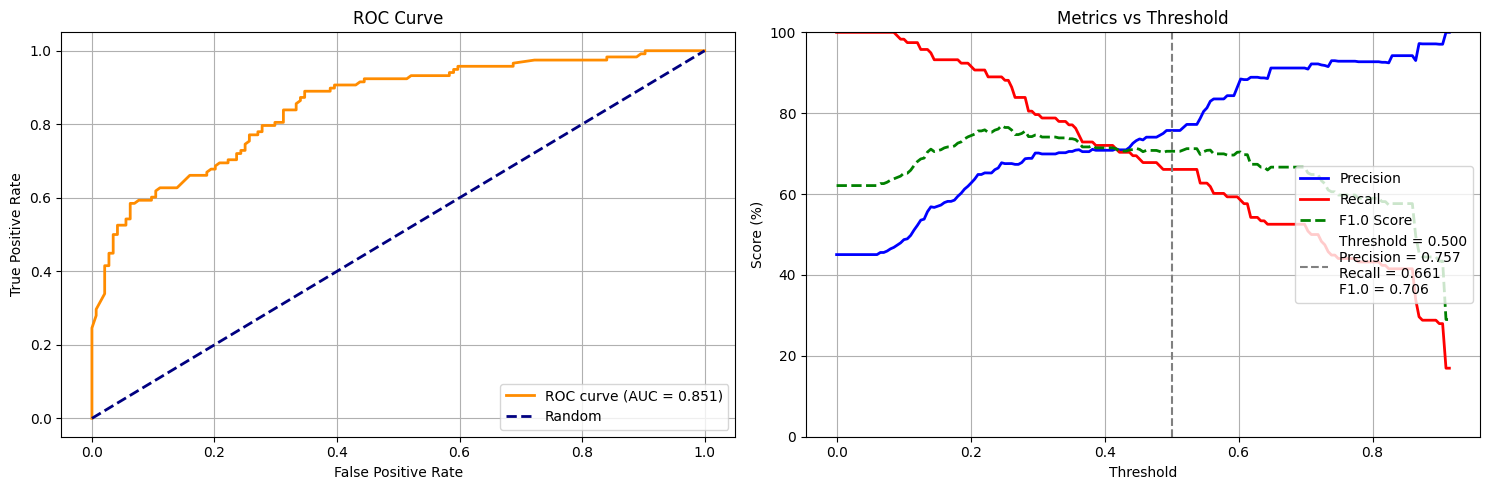

In [198]:
encoding_recommendations=PreProcessor.encoding_recommendations(X_train[selected_cols])
target_encode_cols = encoding_recommendations['target_encode_cols']
# Train and Use the ml pipeline
mlpipeline = ML_PIPELINE(
    model=lgb.LGBMClassifier(
        random_state=42,
        verbose = -1,
        n_estimators=1000,
        early_stopping_round = 100,
        min_child_samples=20,
        scale_pos_weight=1.74
        ),
    preprocessor=PreProcessor(target_encode_cols=target_encode_cols)
)
mlpipeline.fit(X_train[selected_cols], 
               y_train,
               eval_set=(X_val[selected_cols], y_val)
               )
# Summary evaluation report, default threshold and beta
results = mlpipeline.evaluate(X_test[selected_cols], y_test, verbose=True, visualize=True)

In [199]:
print(mlpipeline.model.get_params())

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 1000, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1, 'early_stopping_round': 100, 'scale_pos_weight': 1.74}


# Hyperparameter Tuning


## Metrics for Hyperparameter Tuning

**AUC**
- AUC is a threshold-independent metric that focuses on the overall performance of the model across all possible threshold values.
- It is useful when you want to evaluate the model’s ability to distinguish between positive and negative instances without specifying a threshold.
- With imbalanced classes, a high AUC score means that the model ranks positive examples higher than negative ones, which is still meaningful even if one class dominates the dataset.

**F1**
- Requires defining a threshold (default = 0.5, which may not be optimal).
- It is useful when you want to optimize the trade-off between precision and recall for this specific threshold.
- In imbalanced data, precision, recall and F1 at a fixed threshold (like 0.5) can be misleading.

**Hybrid approach**
- Option A: Optimize AUC first, then tune thresholds: Use AUC for hyperparameter tuning, then adjust the threshold post-training based on F1 or Fbeta. This is a more robust approach as it focus on maximizing overall class separation and is threshold agnostic. 
- Option B: Alternatively, one can also optimizing F1 based on a fixed threshold (e.g., 0.5) first, then try to identify the optimal threshold later. But if the initial hyperparameters are already optimized for F1 at 0.5, adjusting the threshold might not yield as much improvement because the model is already focused on that point. 


| Aspect | F1-First Hybrid | AUC-First Hybrid |
|--------|----------------|------------------|
| Hyperparameter Goal | Maximize F1 at threshold = 0.5 | Maximize overall class separation (AUC) |
| Threshold Flexibility | Limited (hyperparams tuned for 0.5 threshold) | High (hyperparams agnostic to threshold) |
| Class Imbalance | May struggle if default threshold is biased | Robust (focuses on ranking, not fixed threshold) |
| Threshold Optimization | Fixed during hyperparameter tuning | Can be adjusted post-training to optimize any F_beta score based on business needs | 


**Decision**

For ML_PIPELINE, we will take the AUC-first Hybrid approach. 

## Hyperparameter tuning with ML Pipeline

In [200]:

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

titanic = fetch_openml('titanic', version=1, as_frame=True)
X = titanic.data
y = titanic.target.astype(int)  
X = X.drop(['boat', 'body', 'home.dest', 'ticket', 'cabin', 'name'], axis=1)

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, random_state=RANDOM_SEED, train_size = 0.8)
X_train, X_val, y_train_, y_val = train_test_split(X_train_full, y_train_full, random_state=RANDOM_SEED, train_size = 0.8)


In [201]:
# Define the hyperparameter search space
lgb_space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'n_estimators': hp.choice('n_estimators', range(100, 1000, 100)),
    'num_leaves': hp.choice('num_leaves', range(20, 100)),  
    'max_depth': hp.choice('max_depth', range(5, 15)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'subsample': hp.uniform('subsample', 0.6, 0.9)
}

In [202]:
target_encode_cols = PreProcessor.encoding_recommendations(X_train_full)['target_encode_cols']

-------------------------
Column `sex` Analysis:
Recommend one-hot encoding as the number of unique value is less or equal to 2

column `sex` details:
• Missing rate: 0.0%
• Unique values: 2
• Minimum category size: 370
• Rare categories: 0
-------------------------
Column `embarked` Analysis:
Recommend target encoding due to moderate cardinality and sufficient sample size

column `embarked` details:
• Missing rate: 0.1%
• Unique values: 3
• Minimum category size: 100
• Rare categories: 0
-------------------------

Summary:
• Target encoding cols: 1
• One-hot encoding cols: 1


 34%|███▍      | 172/500 [02:19<04:25,  1.23trial/s, best loss: -0.8488152805847662]

Classification Metrics Report

Evaluation Parameters:
Threshold: 0.381
Beta:      1.000

Metrics:
Accuracy:  0.790
F1:        0.758
Precision: 0.784
Recall:    0.734
Pos Rate:  0.419

AUC (threshold independent):
AUC:   0.846


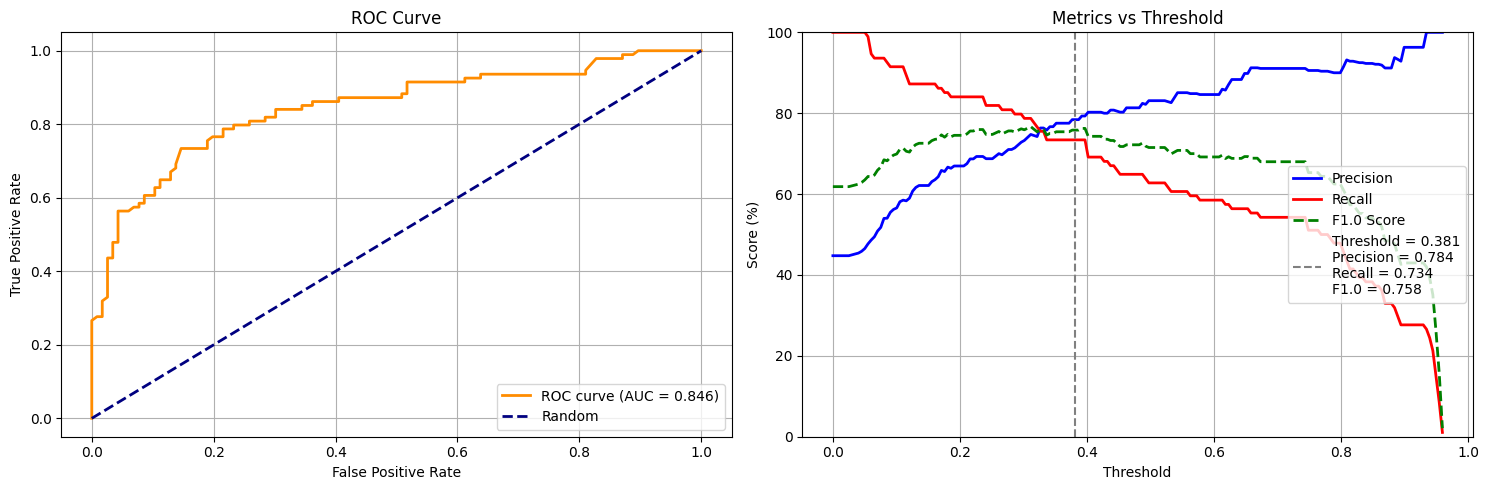


Hyperparameter Tuning Results

Best parameters found:
colsample_bytree: 0.9100710916502652
learning_rate: 0.01004699627026279
max_depth: 14
n_estimators: 300
num_leaves: 25
subsample: 0.6509142221882932


In [203]:
best_lgb_f1 = ML_PIPELINE.tune(X_train_full, y_train_full, 
                               algorithm=lgb.LGBMClassifier, 
                               preprocessor = PreProcessor(target_encode_cols=target_encode_cols),
                               space = lgb_space, 
                               beta = 1,
                               max_evals = 500,
                               early_stopping_rounds = 100,
                               verbose = -1,
                               cv = 5)


Classification Metrics Report

Evaluation Parameters:
Threshold: 0.381
Beta:      1.000

Metrics:
Accuracy:  0.767
F1:        0.726
Precision: 0.771
Recall:    0.686
Pos Rate:  0.401

AUC (threshold independent):
AUC:   0.855


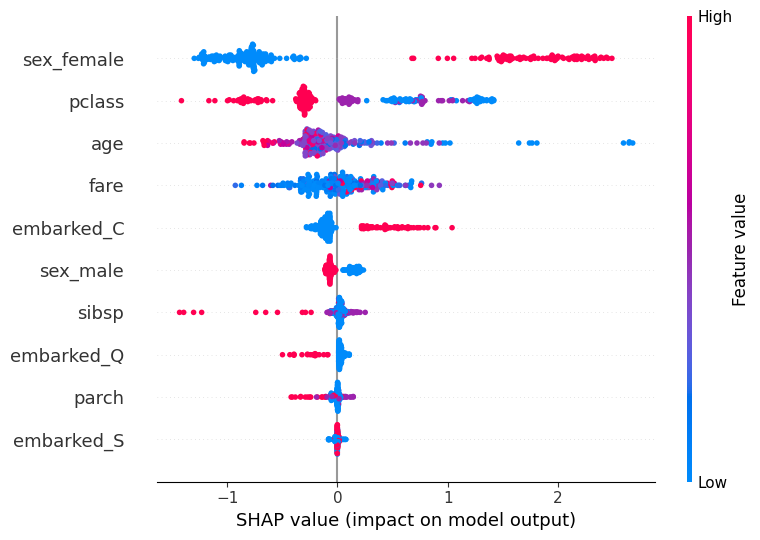

In [204]:
# extract the best model, evaluate with new data and understand its reasoning
best_pipeline = best_lgb_f1['best_pipeline']
beta = best_lgb_f1['beta']
optimal_threshold = best_lgb_f1['optimal_threshold']
metrics = best_pipeline.evaluate(X_test, y_test, optimal_threshold, beta=beta, verbose=True)
best_pipeline.explain_model(X_test)

### Update the Optimal Threshold based on Business Request



Classification Metrics Report

Evaluation Parameters:
Threshold: 0.444
Beta:      0.700

Metrics:
Accuracy:  0.767
F1:        0.705
F_beta:    0.741
Precision: 0.820
Recall:    0.619
Pos Rate:  0.340

AUC (threshold independent):
AUC:   0.855


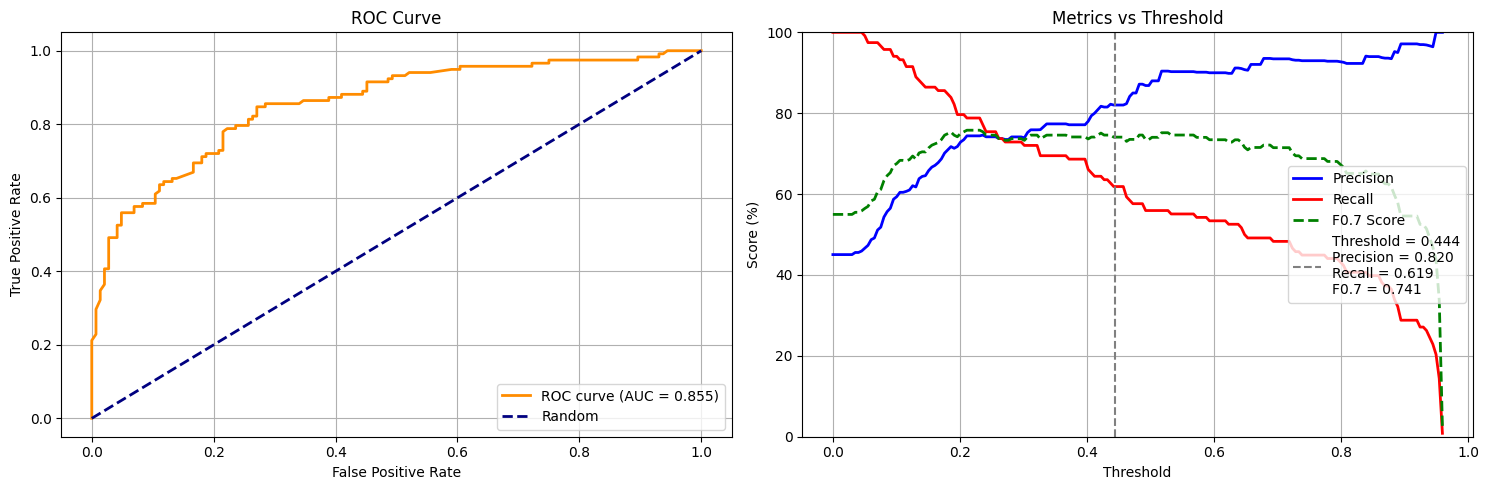

In [205]:
# To give precision twice the weight as recall, set beta to be 0.7 and find the optimal threshold to maximize f_beata 
y_pred_proba = best_pipeline.predict(context = None, model_input = X_train_full)
f07_threshold = ML_PIPELINE.threshold_analysis(y_train_full, y_pred_proba, beta=0.7)['optimal_threshold']
# evaluate the model with new data
f_beta_performance = best_pipeline.evaluate(X_test, y_test, f07_threshold, beta=0.7, verbose = True, visualize=True)

### Swap Algorithm 

Just specify a different algorithm and the search space for it and GO ~

 38%|███▊      | 190/500 [05:04<08:16,  1.60s/trial, best loss: -0.8503846964839845]

Classification Metrics Report

Evaluation Parameters:
Threshold: 0.403
Beta:      1.000

Metrics:
Accuracy:  0.795
F1:        0.762
Precision: 0.793
Recall:    0.734
Pos Rate:  0.414

AUC (threshold independent):
AUC:   0.841


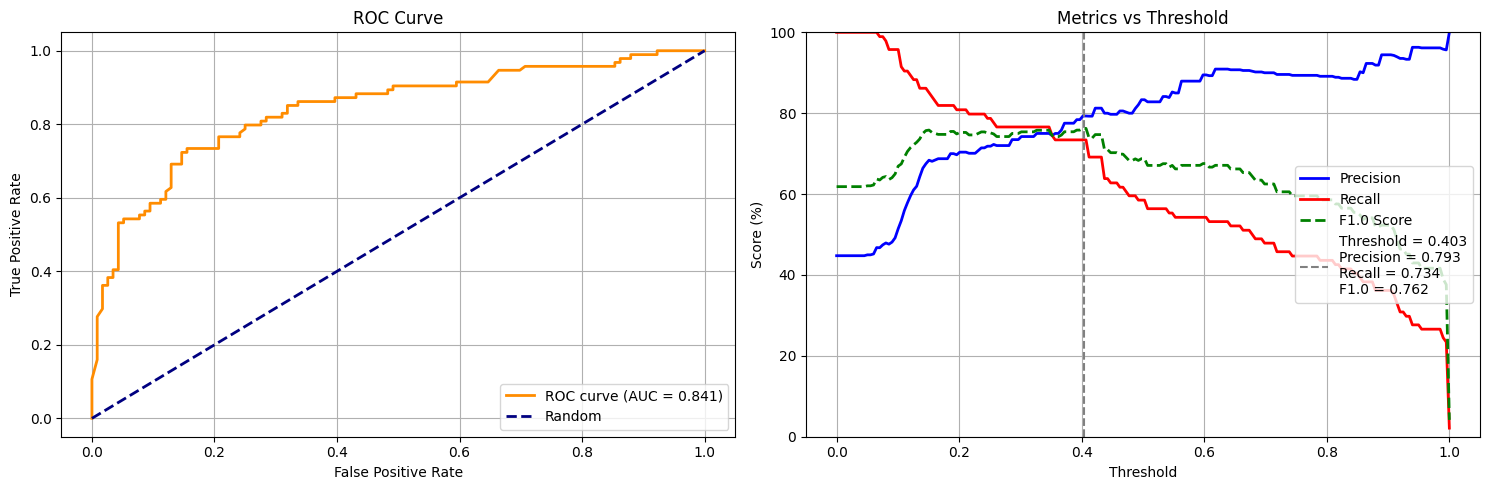


Hyperparameter Tuning Results

Best parameters found:
bootstrap: True
max_depth: 5
max_features: None
min_samples_leaf: 1
min_samples_split: 4
n_estimators: 200


In [206]:

rf_space = {
    'n_estimators': hp.choice('n_estimators', [100, 200, 300, 400, 500]),
    'max_depth': hp.choice('max_depth', [None, *range(5, 31, 5)]), 
    'min_samples_split': hp.choice('min_samples_split', range(2, 20, 2)),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 11)),
    'max_features': hp.choice('max_features', ['sqrt', 'log2', None]),
    'bootstrap': hp.choice('bootstrap', [True, False])
}
best_rf_f1 = ML_PIPELINE.tune(X_train_full, 
                              y_train_full, 
                              preprocessor = PreProcessor(target_encode_cols=target_encode_cols),
                              algorithm=RandomForestClassifier, 
                              space=rf_space, 
                              beta = 1, 
                              cv = 5)


Classification Metrics Report

Evaluation Parameters:
Threshold: 0.403
Beta:      1.000

Metrics:
Accuracy:  0.771
F1:        0.717
Precision: 0.809
Recall:    0.644
Pos Rate:  0.359

AUC (threshold independent):
AUC:   0.860


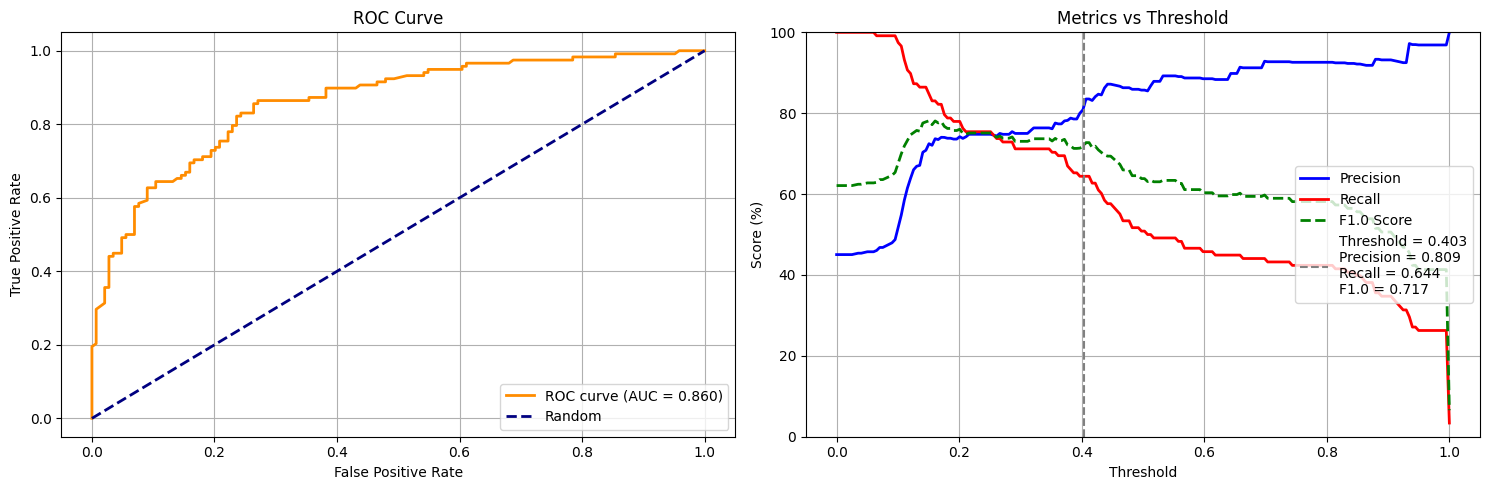

In [207]:
best_pipeline_rf = best_rf_f1['best_pipeline']
beta = best_rf_f1['beta']
optimal_threshold = best_rf_f1['optimal_threshold']
results = best_pipeline_rf.evaluate(X_test, y_test, optimal_threshold, beta, verbose = True, visualize = True)

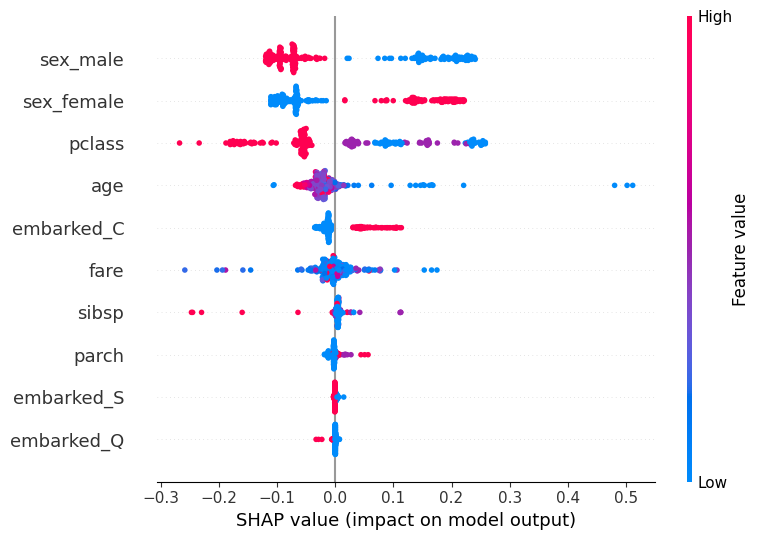

In [208]:
# check the reasoning behind this rf model
best_pipeline_rf.explain_model(X_test)


Classification Metrics Report

Evaluation Parameters:
Threshold: 0.500
Beta:      1.000

Metrics:
Accuracy:  0.740
F1:        0.638
Precision: 0.857
Recall:    0.508
Pos Rate:  0.267

AUC (threshold independent):
AUC:   0.860


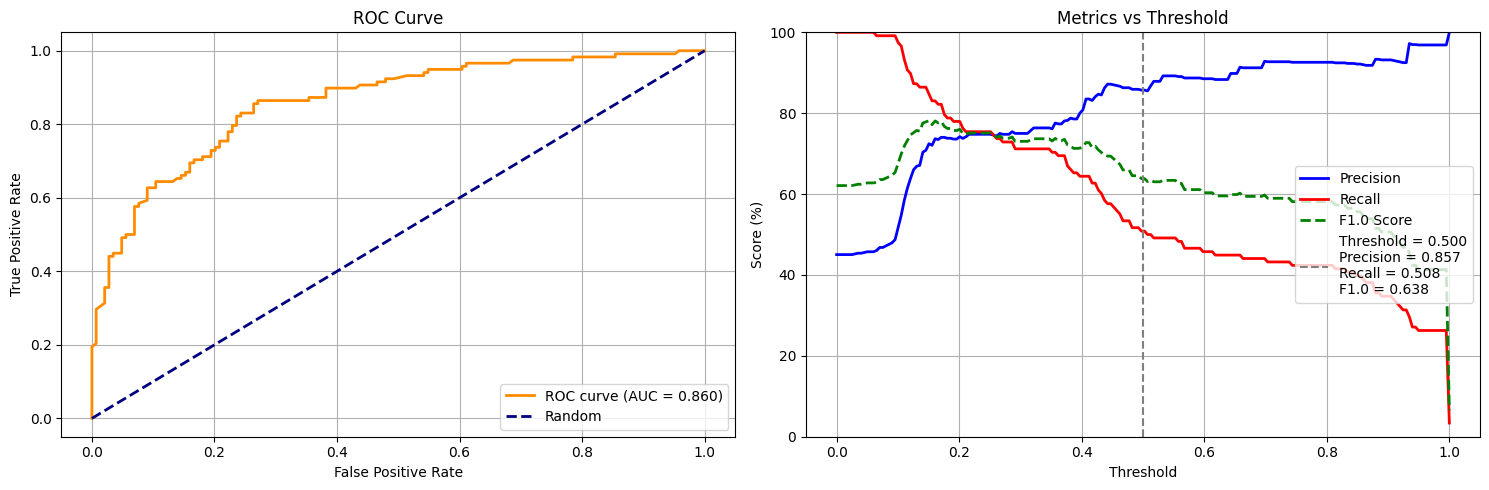

In [209]:
# update the performance based on a given threshold, say the often default 0.5
adjusted_metrics = best_pipeline_rf.evaluate(X_test, y_test, threshold=0.5, verbose=True, visualize=True)

# Backlog tracker

* ~~add early_stop, eval_set to ml_pipeline~~
* ~~use the metrics returned for hyperparameter tuning (iterative tuning)~~
* ~~add a classification problem~~
* ~~add and test early_stopping in tunning~~
* ~~provide a hyperpamameter tuning method to ML pipeline, which allows user to specify space, beta, early_stopping, etc~~
* ~~change the evaluate method, with the optimal threshold provided~~
* ~~offer discussion to compare the auc-first vs f1-first approach for tunning~~
* ~~Optimize threshold based on beta without retune the whole model~~
* ~~Add % of positive predictions in `evaluation` report for classification models.~~
* ~~Use seperate function to do evaluate vs threshold analysis.~~
* ~~Use seperate function to do visuals, roc_auc curve and precision_recall curve with highlighed threshold and f-beta score.~~
* ~~Use CV to find optimal threshold~~
* ~~A precision-recall graph~~
* ~~Update PreProcessor to have a filter_feature_selection method~~
    * ~~recommend dropping one with 1) too many missings, 2) only one value, 3) too low mutual information~~
    * ~~the analysis can return a df with mutual information, missing % and # of unique values~~
    * ~~single responsibility: encoding_recommendations method no longer recommend dropping~~
* add a function to log the best ml pipeline
* consider what's the best way to do nested logging for hyperparameter tuning
* make it less manual to set verbose = -1 for lgb algorithms in tune()
    * Or add note about this wrapper demands some knowledge on the algorithm wrapped, say lgb and verbose = -1
* The optimal way to auto set early stopping rounds
* Clean up the developing process and do more demo with the final PreProcessor and ML_PIPELINE
* For best model from tune, print train performance in addition to the test performance (now the latter only)
* The tune method needs to be updated to work with regression models too
